In [1]:
import numpy as np
import pycolmap
import torch
import torch.nn as nn

from splat.gaussians import Gaussians
from splat.read_utils.read_gs_ply_files import convert_to_gaussian_schema, read_ply_file
from splat.utils import read_images_binary, read_images_text

stem = "/Users/derek/Desktop/intro_to_gaussian_splatting"
# stem = "/home/da2986/intro_to_gaussian_splatting"

models_path = "/Users/derek/Downloads/models/"
ply_path = f"{models_path}/treehill/point_cloud/iteration_7000/point_cloud.ply"
vertices = read_ply_file(ply_path)
gaussians = convert_to_gaussian_schema(vertices)

colmap_path = f"{stem}/data/treehill/sparse/0"
reconstruction = pycolmap.Reconstruction(colmap_path)

points3d = reconstruction.points3D
images = read_images_binary(f"{colmap_path}/images.bin")
cameras = reconstruction.cameras

Vertex Count: 2399849
Properties: [('float', 'x'), ('float', 'y'), ('float', 'z'), ('float', 'nx'), ('float', 'ny'), ('float', 'nz'), ('float', 'f_dc_0'), ('float', 'f_dc_1'), ('float', 'f_dc_2'), ('float', 'f_rest_0'), ('float', 'f_rest_1'), ('float', 'f_rest_2'), ('float', 'f_rest_3'), ('float', 'f_rest_4'), ('float', 'f_rest_5'), ('float', 'f_rest_6'), ('float', 'f_rest_7'), ('float', 'f_rest_8'), ('float', 'f_rest_9'), ('float', 'f_rest_10'), ('float', 'f_rest_11'), ('float', 'f_rest_12'), ('float', 'f_rest_13'), ('float', 'f_rest_14'), ('float', 'f_rest_15'), ('float', 'f_rest_16'), ('float', 'f_rest_17'), ('float', 'f_rest_18'), ('float', 'f_rest_19'), ('float', 'f_rest_20'), ('float', 'f_rest_21'), ('float', 'f_rest_22'), ('float', 'f_rest_23'), ('float', 'f_rest_24'), ('float', 'f_rest_25'), ('float', 'f_rest_26'), ('float', 'f_rest_27'), ('float', 'f_rest_28'), ('float', 'f_rest_29'), ('float', 'f_rest_30'), ('float', 'f_rest_31'), ('float', 'f_rest_32'), ('float', 'f_rest_33'

100%|██████████| 1000/1000 [00:00<00:00, 207690.22it/s]

[-1.1610279083251953, -1.2550954818725586, -1.4310321807861328]
tensor([0.1725, 0.1459, 0.0963])


In [2]:
from splat.image import GaussianImage
from splat.utils import (
    build_rotation,
    get_extrinsic_matrix,
    getIntinsicMatrix,
    read_camera_file,
    read_image_file,
)

camera_dict = read_camera_file(colmap_path)
image_dict = read_image_file(colmap_path)
images = {}
for idx in image_dict.keys():
    image = image_dict[idx]
    camera = camera_dict[image.camera_id]
    image = GaussianImage(camera=camera, image=image)
    images[idx] = image


image_num = 100
rotation_matrix = build_rotation(torch.Tensor(image_dict[image_num].qvec).unsqueeze(0))
translation = torch.Tensor(image_dict[image_num].tvec).unsqueeze(0)
extrinsic_matrix = get_extrinsic_matrix(rotation_matrix, translation).T
focal_x, focal_y = camera_dict[image_dict[image_num].camera_id].params[:2]
c_x, c_y = camera_dict[image_dict[image_num].camera_id].params[2:4]
width = camera_dict[image_dict[image_num].camera_id].width
height = camera_dict[image_dict[image_num].camera_id].height
intrinsic_matrix = getIntinsicMatrix(focal_x, focal_y, height, width).T

In [3]:
from splat.render_engine.utils import compute_fov_from_focal
import math

covariance = gaussians.get_3d_covariance_matrix()[0:1]
mean = gaussians.points[0:1]
t = torch.concat([mean, torch.ones((1, 1))], dim=1)
output = t @ extrinsic_matrix
x = output[:, 0] / output[:, 2]
y = output[:, 1] / output[:, 2]
z = output[:, 2]

print(mean, output, x, y, z)

fovX = compute_fov_from_focal(focal_x, width)
fovY = compute_fov_from_focal(focal_y, height)

tan_fovX = math.tan(fovX / 2)
tan_fovY = math.tan(fovY / 2)

x = torch.clamp(x, -1.3 * tan_fovX, 1.3 * tan_fovX) * output[:, 2]
y = torch.clamp(y, -1.3 * tan_fovY, 1.3 * tan_fovY) * output[:, 2]

j = torch.zeros(1, 3, 3)
j[:, 0, 0] = focal_x / z
j[:, 0, 2] = -(focal_x * x) / (z ** 2)
j[:, 1, 1] = focal_y / z
j[:, 1, 2] = -(focal_y * y) / (z ** 2)

t = extrinsic_matrix[:3, :3].T @ j
print(j)

tensor([[-0.5870,  1.0159,  0.5119]]) tensor([[-0.5247,  2.0070,  3.7276,  1.0000]]) tensor([-0.1408]) tensor([0.5384]) tensor([3.7276])
tensor([[[1131.8634,    0.0000,  159.3323],
         [   0.0000, 1128.2234, -579.9659],
         [   0.0000,    0.0000,    0.0000]]])


In [4]:
from splat.render_engine.gaussianScene2 import GaussianScene2

scene = GaussianScene2(gaussians=gaussians)
scene.device = "cpu"
TILE_SIZE = 16

In [5]:
processed_gaussians = scene.preprocess(
    extrinsic_matrix=extrinsic_matrix,
    intrinsic_matrix=intrinsic_matrix,
    focal_x=focal_x,
    focal_y=focal_y,
    width=width,
    height=height,
    tile_size=TILE_SIZE
)

> /Users/derek/Desktop/intro_to_gaussian_splatting/splat/render_engine/utils.py(124)compute_radius_from_covariance_2d()
    122     """
    123     import pdb; pdb.set_trace()
--> 124     mid = 0.5 * (covariance_2d[:, 0, 0] + covariance_2d[:, 1, 1])
    125     det = covariance_2d[:, 0, 0] * covariance_2d[:, 1, 1] - covariance_2d[:, 0, 1] ** 2
    126     lambda1 = mid + torch.sqrt(torch.clamp(mid**2 - det, min=0.1))

> /Users/derek/Desktop/intro_to_gaussian_splatting/splat/render_engine/utils.py(130)compute_radius_from_covariance_2d()
    128     max_lambda = torch.max(lambda1, lambda2)
    129     import pdb; pdb.set_trace()
--> 130     return std_dev_multiplier * torch.sqrt(max_lambda)
    131 
    132 def ndc2Pix(points: torch.Tensor, height: float, width: float) -> torch.Tensor:

tensor([3.4609e+01, 2.8586e+01, 5.5722e+01, 3.0558e+01, 5.6735e+01, 3.6710e+01,
        5.9982e+01, 2.0111e+01, 1.0351e+00, 5.0738e+01, 5.9476e+01, 2.3972e+01,
        3.5723e+01, 5.8584e+01, 2.8337e+01, 

In [6]:
processed_gaussians.radius

tensor([2.3017e+02, 1.5592e+02, 2.2922e+02, 1.7481e+02, 2.6020e+02, 1.8032e+02,
        1.9609e+02, 1.3035e+02, 3.1415e+01, 2.6113e+02, 2.3736e+02, 1.3991e+02,
        2.4149e+02, 2.1396e+02, 1.6239e+02, 1.9105e+02, 1.5474e+02, 1.9381e+02,
        2.1274e+02, 2.9307e+02, 1.9047e+02, 2.1320e+02, 1.2888e+02, 2.4115e+02,
        1.3286e+02, 2.0576e+02, 1.3190e+02, 1.3215e+02, 1.9384e+02, 1.4371e+02,
        1.5129e+02, 2.2923e+02, 2.2097e+02, 2.0582e+02, 1.3825e+02, 1.3311e+02,
        1.3430e+02, 1.5723e+02, 1.8687e+02, 1.4063e+02, 1.9317e+02, 2.6994e+02,
        1.1854e+02, 2.2307e+02, 2.5221e+02, 2.0865e+02, 1.4323e+02, 1.7764e+02,
        2.0245e+02, 1.7332e+02, 1.4348e+02, 1.8265e+02, 1.7610e+02, 1.5399e+02,
        2.4425e+02, 2.8088e+01, 2.1943e+02, 1.8330e+02, 1.6986e+02, 2.4760e+02,
        4.8513e+01, 2.0930e+02, 1.3406e+02, 2.0219e+02, 2.7402e+02, 6.5452e+01,
        1.8272e+02, 2.2202e+02, 2.0833e+02, 2.3916e+02, 1.3891e+02, 2.5402e+02,
        2.4550e+02, 2.0235e+02, 2.3725e+

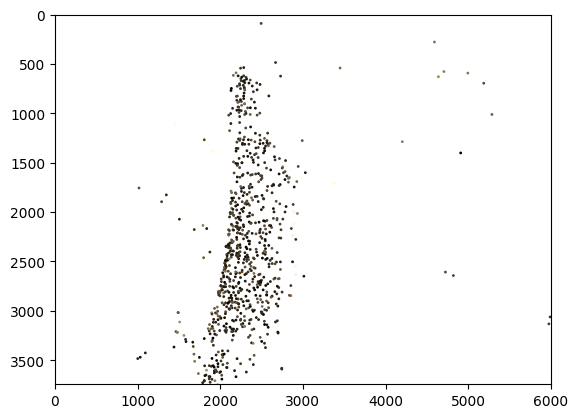

In [8]:
import matplotlib.pyplot as plt

plt.scatter(
    processed_gaussians.means_3d[:, 0].detach().cpu(),
    processed_gaussians.means_3d[:, 1].detach().cpu(),
    c=processed_gaussians.color.detach().cpu(),
    s=1,
)

plt.xlim(0, 6000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
from PIL import Image

image_path = "/Users/derek/Desktop/intro_to_gaussian_splatting/data/treehill/images/_DSC8973.JPG"
image = Image.open(image_path)

plt.imshow(image)
plt.show()